# Galaxy Classification, Anomaly Detection, Autoencoder & VAE (Keras)
This notebook uses the Galaxy10 DECaLS dataset (astronomical galaxy images) for:

1. Data loading & splitting, defining an anomaly class  
2. CNN classifier + ROC curves & confusion matrices  
3. Convolutional autoencoder for anomaly detection  
4. Variational autoencoder (VAE) + galaxy generation

Dataset: Galaxy10 DECaLS (HDF5).


In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
from keras import layers, ops, Model, random

import numpy as np
import h5py
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

## 1. Download the dataset, inspect classes, create anomaly split

Steps:
- Download `Galaxy10_DECals_64.h5`
- Load images and labels with `h5py`
- Inspect shape and class distribution
- Remove class 4 and store it as the anomaly dataset
- Split remaining (standard) data into train (50%), val (25%), test (25%)

In [2]:
# Download Galaxy10 DECaLS (HDF5)
! rm ./Galaxy10_DECals_64.h5
! wget https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
data_path = "./Galaxy10_DECals_64.h5"

print("Downloaded to:", data_path)


rm: cannot remove './Galaxy10_DECals_64.h5': No such file or directory
--2025-11-26 17:25:58--  https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.35, 128.142.170.17, 137.138.120.151, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159140118 (152M) [application/octet-stream]
Saving to: ‘Galaxy10_DECals_64.h5’

Galaxy10_DECals_64. 100%[===================>] 151.77M   153KB/s    in 16m 6s  

2025-11-26 17:42:05 (161 KB/s) - ‘Galaxy10_DECals_64.h5’ saved [159140118/159140118]

Downloaded to: ./Galaxy10_DECals_64.h5


In [1]:
# Copy data onto drive s.t. dont need to download every time
from google.colab import drive
drive.mount('/content/drive')

import os
from pathlib import Path

# Pfade
drive_path = Path("/content/drive/MyDrive/Galaxy10_DECals_64.h5")
local_path = Path("./Galaxy10_DECals_64.h5")

#!cp "./Galaxy10_DECals_64.h5" "/content/drive/MyDrive/Galaxy10_DECals_64.h5"

# 1. case: data not on google drive
if not drive_path.exists():
    print("start download from cern...")
    !wget -O "{drive_path}" https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
    print("finished download from cern!")
else:
    print("dataset already on google drive")

# 2. case: data on google drive
if not local_path.exists():
    print("copy data from google drive into colab")
    !cp "{drive_path}" "{local_path}"
else:
    print("data already in colab")

# Endgültiger Pfad für den Rest deines Codes
data_path = "./Galaxy10_DECals_64.h5"
print(f"Data path: {data_path}")

Mounted at /content/drive
dataset already on google drive
copy data from google drive into colab
Data path: ./Galaxy10_DECals_64.h5


In [3]:
# Load images and labels using h5py
with h5py.File(data_path, "r") as f:
    images = np.array(f["images"])   # shape (17736, 256, 256, 3)
    labels = np.array(f["ans"])      # shape (17736,)

#  normalize pixels in [0,1]
images = images/255

print("Images shape:", images.shape)
print("Labels shape:", labels.shape, "dtype:", labels.dtype)

Images shape: (17736, 64, 64, 3)
Labels shape: (17736,) dtype: uint8


In [4]:
# Class names from the Galaxy10 DECaLS documentation
class_names = {
    0: "Disturbed Galaxies",
    1: "Merging Galaxies",
    2: "Round Smooth Galaxies",
    3: "In-between Round Smooth Galaxies",
    4: "Cigar Shaped Smooth Galaxies",  # will be 'anomaly'
    5: "Barred Spiral Galaxies",
    6: "Unbarred Tight Spiral Galaxies",
    7: "Unbarred Loose Spiral Galaxies",
    8: "Edge-on Galaxies without Bulge",
    9: "Edge-on Galaxies with Bulge"
}

unique, counts = np.unique(labels, return_counts=True)
print("Class distribution:")
for u, c in zip(unique, counts):
    print(f"Class {u} ({class_names[u]}): {c}")

Class distribution:
Class 0 (Disturbed Galaxies): 1081
Class 1 (Merging Galaxies): 1853
Class 2 (Round Smooth Galaxies): 2645
Class 3 (In-between Round Smooth Galaxies): 2027
Class 4 (Cigar Shaped Smooth Galaxies): 334
Class 5 (Barred Spiral Galaxies): 2043
Class 6 (Unbarred Tight Spiral Galaxies): 1829
Class 7 (Unbarred Loose Spiral Galaxies): 2628
Class 8 (Edge-on Galaxies without Bulge): 1423
Class 9 (Edge-on Galaxies with Bulge): 1873


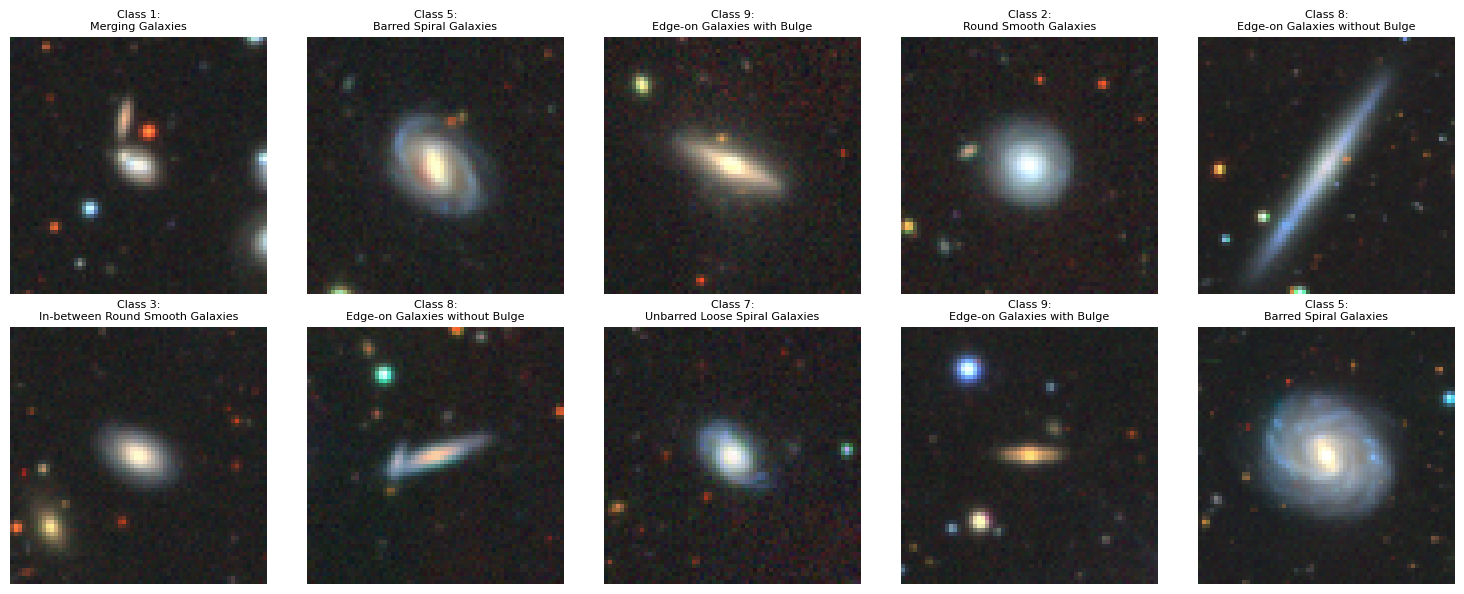

In [5]:
# Show a grid of sample images from different classes
def show_examples(images, labels, class_names, n_rows=2, n_cols=5):
    plt.figure(figsize=(3*n_cols, 3*n_rows))
    indices = np.random.choice(len(images), size=n_rows*n_cols, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(images[idx])
        plt.title(f"Class {labels[idx]}:\n{class_names[int(labels[idx])]}", fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_examples(images, labels, class_names)

In [6]:
# Create anomaly dataset: all class 4 images
ANOMALY_CLASS = 4

anomaly_mask = (labels == ANOMALY_CLASS)
standard_mask = ~anomaly_mask

anom_images = images[anomaly_mask]
anom_labels = labels[anomaly_mask]  # all 4, but we keep them for bookkeeping

std_images = images[standard_mask]
std_labels_original = labels[standard_mask]

print("Standard images:", std_images.shape)
print("Anomaly images:", anom_images.shape)

Standard images: (17402, 64, 64, 3)
Anomaly images: (334, 64, 64, 3)


In [7]:
# For training, remap standard labels from {0,1,2,3,5,6,7,8,9} -> {0,...,8}
unique_std_classes = sorted(np.unique(std_labels_original))
print("Standard classes (original indices):", unique_std_classes)

# Create mapping dict
label_map = {original: new for new, original in enumerate(unique_std_classes)}
inv_label_map = {v: k for k, v in label_map.items()}

print("Label map (original -> new):", label_map)

std_labels = np.vectorize(label_map.get)(std_labels_original)
print("Remapped standard labels min/max:", std_labels.min(), std_labels.max())
n_classes = len(unique_std_classes)

Standard classes (original indices): [np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9)]
Label map (original -> new): {np.uint8(0): 0, np.uint8(1): 1, np.uint8(2): 2, np.uint8(3): 3, np.uint8(5): 4, np.uint8(6): 5, np.uint8(7): 6, np.uint8(8): 7, np.uint8(9): 8}
Remapped standard labels min/max: 0 8


In [8]:
# Split standard data: 50% train, 25% val, 25% test

# First split: train (50%) and temp (50%)
X_train_std, X_temp_std, y_train_std, y_temp_std = train_test_split(
    std_images,
    std_labels,
    test_size=0.5,
    stratify=std_labels,
    random_state=42
)

# Second split: temp into val (25%) and test (25%) of full standard data
X_val_std, X_test_std, y_val_std, y_test_std = train_test_split(
    X_temp_std,
    y_temp_std,
    test_size=0.5,
    stratify=y_temp_std,
    random_state=42
)

print("Train standard:", X_train_std.shape, y_train_std.shape)
print("Val standard:  ", X_val_std.shape, y_val_std.shape)
print("Test standard: ", X_test_std.shape, y_test_std.shape)
del std_images, std_labels, X_temp_std, y_temp_std

Train standard: (8701, 64, 64, 3) (8701,)
Val standard:   (4350, 64, 64, 3) (4350,)
Test standard:  (4351, 64, 64, 3) (4351,)


## 2. CNN classifier + ROC curves + confusion matrices

Steps:
- Build a CNN classifier on the **standard** dataset (9 classes)
- Train on train set, validate on val set
- Plot training history (loss & accuracy)
- Compute ROC curves (one-vs-rest) on the standard test set
- Compute confusion matrix for standard test

In [10]:
from keras.src.utils import to_categorical

# Convert labels into one-hot encoding
y_train_enc = to_categorical(y_train_std, 9)
y_val_enc = to_categorical(y_val_std, 9)
y_test_enc = to_categorical(y_test_std, 9)

print(y_train_enc[0])

[0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [ ]:
from keras.src.layers.activations.activation import Activation
from keras.src.layers.pooling.average_pooling2d import AveragePooling2D
from keras.src.layers.normalization.batch_normalization import BatchNormalization
from keras import layers, models

# CNN model for standard dataset
classifier_model = models.Sequential([
    # first layer
    layers.Conv2D(16, (5, 5), input_shape=(64, 64, 3)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.35),

    # second layer
    layers.Conv2D(16, (3, 3)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.AveragePooling2D((5, 5)),
    layers.Dropout(0.35),

    # third layer
    layers.Conv2D(16, (3, 3)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.AveragePooling2D((3, 3)),
    layers.Dropout(0.35),

    # classifier layer
    layers.Flatten(),
    layers.Dense(128),
    layers.Activation("relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")
])

# compile the model
compile(optimer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

## 3. Convolutional Autoencoder for anomaly detection

Steps:
- Train a convolutional autoencoder on **standard** train set only
- Plot training history
- Compute reconstruction loss (MSE) per image for:
  - Standard test set
  - Anomaly dataset (class 4)
- Plot histograms of reconstruction losses
- Use reconstruction loss as anomaly score and build ROC curve & confusion matrix (adapt provided code)

## 4. Variational Autoencoder (VAE) on standard data

Steps:
- Build a VAE with convolutional encoder/decoder (trained on standard train set)
- Plot training history
- Generate new galaxy images from the VAE
- Visualize some generated images